## Set-up

### Imports

In [1]:
import datetime
import glob
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')  # https://matplotlib.org/users/style_sheets.html
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy import stats
from sklearn import manifold, decomposition, preprocessing
import seaborn as sns
import time

from AlienTask import Task
from shared_aliens import update_Qs_sim, get_alien_paths, get_alien_initial_q,\
    get_summary_initial_learn, get_summary_cloudy, simulate_competition_phase, simulate_rainbow_phase, get_summary_rainbow,\
    read_in_human_data, se

C:\Users\maria\MEGAsync\SLCN\models\shared_aliens.py:439: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert((n_hum == len(comp_file_names)), "The competition files and initial learning files are not for the same subjects!")


### Switches

In [2]:
# Define things
# run_on_cluster = False
# do_analyze_humans = False
# do_calculate_best_summary = False
# do_calculate_summaries = True
# do_read_in_and_visualize_summaries = True
do_isomap = False
do_save_selected_agents = True
# if do_isomap:
#     from sklearn import manifold, decomposition, preprocessing
# Which model will be simulated?
model_name = 'hier'
models = ['hier', 'Bayes', 'flat']
n_sim_per_subj, n_subj = 1, 26  # n_sim_per_sub = 20, n_subj = 31 (version3.1)  # TODO should be 1, 31-x (1 sim per person; exclude excluded subjects)
n_sim = n_sim_per_subj * n_subj
n_actions, n_aliens, n_seasons, n_TS = 3, 4, 3, 3
alien_initial_Q = get_alien_initial_q(model_name)

In [3]:
# Data paths
## Where is human experimental data stored?
human_data_path = get_alien_paths()["human data prepr"]

## Where will simulated summaries be saved or read in?
summary_save_dir = os.path.join(get_alien_paths(False)['fitting results'], 'SummariesInsteadOfFitting_revision')
full_summary_save_dir = os.path.join(summary_save_dir, 'FullSimulations')

## Where will plots be saved that we create here?
plot_save_dir = os.path.join(summary_save_dir, 'plots')  # 'C:/Users/maria/MEGAsync/Berkeley/TaskSets/paperplots/'

In [4]:
# Allowed parameter ranges to be sampled from
if model_name == 'hier':
    param_names = ['alpha', 'beta', 'forget', 'alpha_high', 'beta_high', 'forget_high']
    param_ranges = pd.DataFrame.from_dict(
        {'alpha': [0, 1], 'beta': [1, 20], 'forget': [0, 1],
         'alpha_high': [0, 1], 'beta_high': [1, 20], 'forget_high': [0, 1]
         })
    
elif model_name == 'flat':
    param_names = ['alpha', 'beta', 'forget']
    param_ranges = pd.DataFrame.from_dict({'alpha': [0, 1], 'beta': [1, 20], 'forget': [0, 1]})
    
elif model_name == 'Bayes':
    param_names = ['alpha', 'beta', 'forget', 'beta_high', 'forget_high']
    param_ranges = pd.DataFrame.from_dict(
        {'alpha': [0, 1], 'beta': [1, 20], 'forget': [0, 1],
         'beta_high': [1, 20], 'forget_high': [0, 1]
         })
    
else:
    raise(NameError, 'model_name must be "flat", "Bayes", or "hier"!')

In [5]:
# Column names for the simulation summary measures
## Initial learning phase
IL_cols = ['IL_saving_av', 'IL_saving_first_trial', 'IL_saving_last_trial',  # savings
           'IL_acc_current_TS', 'IL_acc_prev_TS', 'IL_acc_other_TS',  # intrusion errors
           'IL_acc_current_TS_se', 'IL_acc_prev_TS_se', 'IL_acc_other_TS_se',
           'IL_perf_TS0', 'IL_perf_TS1', 'IL_perf_TS2',  # TS values
           'IL_perf_TS0_se', 'IL_perf_TS1_se', 'IL_perf_TS2_se', 'IL_perf_TS_corr'
           ]

## Cloudy phase
CL_cols = ['CL_acc_trial0', 'CL_acc_trial1', 'CL_acc_trial2', 'CL_acc_trial3',
           'CL_acc_trial0_se', 'CL_acc_trial1_se', 'CL_acc_trial2_se', 'CL_acc_trial3_se',
           'CL_slope', 'CL_slope_TS0', 'CL_slope_TS1', 'CL_slope_TS2']  # TS reactivation

## Competition phase
CO_cols = ['CO_acc_season', 'CO_acc_season_alien', 'CO_acc_season_se', 'CO_acc_season_alien_se']  # competition alien values & TS values

## Rainbow phase
RB_cols = ['RB_alien0_action0', 'RB_alien0_action1', 'RB_alien0_action2',
           'RB_alien1_action0', 'RB_alien1_action1', 'RB_alien1_action2',
           'RB_alien2_action0', 'RB_alien2_action1', 'RB_alien2_action2',
           'RB_alien3_action0', 'RB_alien3_action1', 'RB_alien3_action2']
RB_sum_cols = ['TS0', 'TS1', 'TS2', 'None', 'TS0_se', 'TS1_se', 'TS2_se', 'None_se', 'TS2minusTS0']
summary_dat_cols = param_names + IL_cols + CL_cols + CO_cols + RB_cols

In [6]:
# Create task, get numbers of trials for each phase
task = Task(n_subj)
n_trials, _, _, _, _ = task.get_trial_sequence(get_alien_paths(False)["human data prepr"],
                                         n_subj, n_sim_per_subj, range(n_subj),
                                         phases=("1InitialLearning", "2CloudySeason"))

n_trials_ = {'1InitialLearn': np.sum(task.phase == '1InitialLearning'),
             '2CloudySeason': np.sum(task.phase == '2CloudySeason'),
             '4RainbowSeason': 4 * n_aliens,
             '5Competition': 3}

trials = {'1InitialLearn': range(n_trials_['1InitialLearn']),
          '2CloudySeason': range(n_trials_['1InitialLearn'],
                                 n_trials_['1InitialLearn'] + n_trials_['2CloudySeason'])}

## Create summaries

In [24]:
# Function to calculate summaries
def get_summary(parameters, param_ranges, n_sim, n_subj, model, summary_or_fulldata='summary'):

    # Get parmaeters
    ## Scale parameters correctly
    parameters = param_ranges.loc[0] + (param_ranges.loc[1] - param_ranges.loc[0]) * parameters

    beta_shape = (n_sim, 1)  # Q_low_sub.shape -> [n_subj, n_actions]
    beta_high_shape = (n_sim, 1)  # Q_high_sub.shape -> [n_subj, n_TS]
    forget_shape = (n_sim, 1, 1, 1)  # Q_low[0].shape -> [n_subj, n_TS, n_aliens, n_actions]
    forget_high_shape = (n_sim, 1, 1)  # -> [n_subj, n_seasons, n_TS]

    ## Parameters present in all models (flat RL, hier RL, Bayes)
    alpha = parameters['alpha'] * np.ones(n_sim)
    beta = parameters['beta'] * np.ones(beta_shape)
    forget = parameters['forget'] * np.ones(forget_shape)

    ## Deal with parameters that exist only in some models
    try:
        alpha_high = parameters['alpha_high'] * np.ones(n_sim)
    except KeyError:
        alpha_high = np.zeros(n_sim)
    try:
        beta_high = parameters['beta_high'] * np.ones(beta_high_shape)
    except KeyError:
        beta_high = np.zeros(beta_high_shape)
    try:
        forget_high = parameters['forget_high'] * np.ones(forget_high_shape)
    except KeyError:
        forget_high = np.zeros(forget_high_shape)

    # Initial learning phase
    ## Set up data storage
    seasons = np.zeros([n_trials, n_sim], dtype=int)
    corrects = np.zeros([n_trials, n_sim])
    rewards = np.zeros([n_trials, n_sim])
    aliens = np.zeros([n_trials, n_sim], dtype=int)
    actions = np.zeros([n_trials, n_sim], dtype=int)

    ## Inialize Q-values
    Q_low = alien_initial_Q * np.ones([n_sim, n_TS, n_aliens, n_actions])
    Q_high = alien_initial_Q * np.ones([n_sim, n_seasons, n_TS])

    ## Simulate behavior
    for trial in trials['1InitialLearn']:

        ### Observe stimuli
        season, alien = task.present_stimulus(trial)

        ### Select action & update Q-values
        [Q_low, Q_high, TS, action, correct, reward, p_low] =\
            update_Qs_sim(season, alien,
                          Q_low, Q_high,
                          beta, beta_high, alpha, alpha_high, forget, forget_high,
                          n_sim, n_actions, n_TS, task, alien_initial_Q, model_name)

        ### Store trial data
        seasons[trial] = season
        corrects[trial] = correct
        rewards[trial] = reward
        aliens[trial] = alien
        actions[trial] = action

    ## Save final Q-values for subsequent phases
    final_Q_low = Q_low.copy()
    final_Q_high = Q_high.copy()

    ## Calculate summaries for initial learning phase
    summary_initial_learn = get_summary_initial_learn(
        seasons[trials['1InitialLearn']], corrects[trials['1InitialLearn']],
        aliens[trials['1InitialLearn']], actions[trials['1InitialLearn']],
        n_seasons, n_sim, trials, task)

    # Cloudy season
    for trial in trials['2CloudySeason']:

        ## Observe trial stimuli
        old_season = season.copy()
        season, alien = task.present_stimulus(trial)

        ## Season switches
        if trial == list(trials['2CloudySeason'])[0]:
            season_switches = np.ones(n_sim, dtype=bool)
        else:
            season_switches = season != old_season

        ## Reset Q-values after season switches
        if (model_name == 'hier') or (model_name == 'Bayes'):
            Q_high[season_switches] = alien_initial_Q  # re-start search for the right TS when season changes
        elif model_name == 'flat':
            Q_low[season_switches] = alien_initial_Q  # re-learn a new policy from scratch when season changes
        else:
            raise(NameError, 'Model_name must be "flat", "hier", or "Bayes".')

        ## Update Q-values
        [Q_low, Q_high, TS, action, correct, reward, p_low] =\
            update_Qs_sim(0 * season, alien,
                          Q_low, Q_high,
                          beta, beta_high, alpha, alpha_high, forget, forget_high,
                          n_sim, n_actions, n_TS, task, alien_initial_Q, model_name)

        ## Store trial data
        seasons[trial] = season
        corrects[trial] = correct
        if summary_or_fulldata == 'fulldata':
            rewards[trial] = reward
            aliens[trial] = alien
            actions[trial] = action

    ## Calculate summaries for cloudy phase
    summary_cloudy = get_summary_cloudy(seasons, corrects, n_sim, trials['2CloudySeason'])

    # Run and get summaries for competition phase
    comp_data = simulate_competition_phase(model_name, final_Q_high, final_Q_low, task,
                                           n_seasons, n_aliens, n_sim, beta_high, n_blocks_comp=n_trials_['5Competition'])
#     summary_competition = comp_data.groupby('phase').aggregate('mean')['perc_selected_better'].values
    summary_competition = comp_data.groupby('phase').aggregate('mean').reset_index()[['perc_selected_better', 'se']].T.values.flatten()
    summary_competition = pd.DataFrame(data=summary_competition, index=CO_cols)
    
    # Run and get summaries for rainbow season
    rainbow_dat = simulate_rainbow_phase(n_seasons, model_name, n_sim,
                                         beta, beta_high, final_Q_low, final_Q_high)
    rainbow_dat = pd.DataFrame(data=rainbow_dat.flatten(), index=RB_cols)

    # Return list of summaries  # TODO would be better as pd.DataFrame, dict, etc.
#     if summary_or_fulldata == 'summary':
#         return list(parameters.values) + summary_initial_learn + list(summary_cloudy) + list(summary_competition) + list(rainbow_dat.flatten())
    if summary_or_fulldata == 'summary':
        return pd.concat([parameters, summary_initial_learn, summary_cloudy, summary_competition, rainbow_dat])
    elif summary_or_fulldata == 'fulldata':
        return (seasons, corrects, rewards, aliens, actions)
    else:
        raise ValueError('summary_or_fulldata must either be "summary" or "fulldata".')

In [30]:

params = np.random.rand(len(param_names))
# a = get_summary(
#     params, param_ranges, n_sim, n_subj, model_name, summary_or_fulldata='summary')

# a = np.random.rand(3 * 3).reshape(3, 3)
# b = np.mean(a, axis=0)
# pd.DataFrame(b, index=['a', 'b', 'c'])

# a.reset_index()

# # param_ranges
# parameters = param_ranges.loc[0] + (param_ranges.loc[1] - param_ranges.loc[0]) * params
# a = pd.DataFrame(parameters).T.reset_index()

# pd.DataFrame(data=a, index=['a', 'b', 'c'])
# a.values
# b = pd.DataFrame(data=np.random.rand(3), index=['c', 'd', 'e'])
# pd.concat([a, b])
# pd.DataFrame(data=[np.corrcoef(a.values.flatten(), np.arange(3))[0, 1]], index=['a'])
a#.T.values.flatten()
b = a.copy()
e = pd.DataFrame()
pd.concat([e, a, b], axis=1)

,0,0
alpha,0.057387,0.057387
beta,15.911992,15.911992
forget,0.311737,0.311737
alpha_high,0.879680,0.879680
beta_high,6.568807,6.568807
forget_high,0.008555,0.008555
IL_saving_av,-0.013807,-0.013807
IL_saving_first_trial,-0.179487,-0.179487
IL_saving_last_trial,0.038462,0.038462
IL_acc_current_TS,0.285714,0.285714


In [7]:
a = pd.DataFrame({'a': [1], 'b': [2]}).reset_index()
b = pd.DataFrame({'c': [3], 'd': [4]}).reset_index()
pd.merge(a, b)

,index,a,b,c,d
0,0,1,2,3,4


In [34]:
summaries

,model,0,0,0,0,0
CL_acc_trial0,NaN,0.273504,0.324786,0.358974,0.260684,0.260684
CL_acc_trial0_se,NaN,0.028496,0.024116,0.030404,0.025600,0.032514
CL_acc_trial1,NaN,0.316239,0.316239,0.363248,0.277778,0.316239
CL_acc_trial1_se,NaN,0.031804,0.028148,0.036038,0.030369,0.032373
CL_acc_trial2,NaN,0.290598,0.282051,0.282051,0.269231,0.329060
CL_acc_trial2_se,NaN,0.022675,0.026503,0.026503,0.039248,0.023779
CL_acc_trial3,NaN,0.294872,0.294872,0.333333,0.354701,0.286325
CL_acc_trial3_se,NaN,0.026304,0.026989,0.027695,0.027041,0.026463
CL_slope,NaN,0.019231,-0.061966,-0.079060,0.136752,0.044872
CL_slope_TS0,NaN,0.044872,-0.121795,-0.166667,0.230769,0.006410


In [35]:
save_frequency = 100
print_frequency = 1
n_frames = 1
n_sims_per_frame = 5

# Get summaries for different parameters
new_time = time.time()

for frame_i in range(n_frames):
    summaries = pd.DataFrame()

    for sim_i in range(n_sims_per_frame):
        params = np.random.rand(len(param_names))
        new_summary = get_summary(
            params, param_ranges, n_sim, n_subj, model_name, summary_or_fulldata='summary')
        summaries = pd.concat([summaries, new_summary], axis=1)

        if (sim_i % print_frequency) == 0:

            # Print progress
            print("\n\tIteration {}".format(sim_i))
            old_time = new_time
            new_time = time.time()
            diff = new_time - old_time
            print("Time passed: {} seconds".format(np.round(diff)))

        if ((sim_i % save_frequency) == 0) or (sim_i == n_sims_per_frame - 1):

            # Save summaries to disk
            save_path = os.path.join(summary_save_dir, model_name + '_summariesTEST_{}.csv'.format(frame_i))
            save_summaries = summaries.T
            save_summaries['model'] = model_name
            save_summaries.to_csv(save_path)
            print("Saving summaries to {}".format(save_path))


	Iteration 0
Time passed: 2.0 seconds
Saving summaries to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\hier_summariesTEST_0.csv

	Iteration 1
Time passed: 2.0 seconds

	Iteration 2
Time passed: 2.0 seconds

	Iteration 3
Time passed: 1.0 seconds

	Iteration 4
Time passed: 1.0 seconds
Saving summaries to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\hier_summariesTEST_0.csv


In [561]:
# Test reliability of results
save_frequency = 20
print_frequency = 20
n_frames = 10
n_sims_per_frame = 100

# Get summaries for different parameters
new_time = time.time()

for frame_i in range(n_frames):
    summaries = pd.DataFrame(
        np.full((n_sims_per_frame, 1 + len(summary_dat_cols)), np.nan),
        columns=summary_dat_cols + ['model'])
    summaries['model'] = model_name

    params = np.random.rand(len(param_names))
    for sim_i in range(n_sims_per_frame):
        summaries.loc[sim_i, :-1] = get_summary(
            params, param_ranges, n_sim, n_subj, model_name, summary_or_fulldata='summary')

        if (sim_i % print_frequency) == 0:

            # Print progress
            print("\n\tIteration {}".format(sim_i))
            old_time = new_time
            new_time = time.time()
            diff = new_time - old_time
            print("Time passed: {} seconds".format(np.round(diff)))

        if ((sim_i % save_frequency) == 0) or (sim_i == n_sims_per_frame - 1):

            # Save summaries to disk
            save_path = os.path.join(summary_save_dir, model_name + '_summaries_reliabtest_{}.csv'.format(frame_i))
            summaries.to_csv(save_path)
            print("Saving summaries to {}".format(save_path))


	Iteration 0
Time passed: 2.0 seconds
Saving summaries to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\hier_summaries_reliabtest_0.csv

	Iteration 20
Time passed: 29.0 seconds
Saving summaries to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\hier_summaries_reliabtest_0.csv

	Iteration 40
Time passed: 28.0 seconds
Saving summaries to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\hier_summaries_reliabtest_0.csv

	Iteration 60
Time passed: 28.0 seconds
Saving summaries to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\hier_summaries_reliabtest_0.csv

	Iteration 80
Time passed: 28.0 seconds
Saving summaries to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\hier_summaries_reliabtest_0.csv
Saving summaries to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/Summar

Saving summaries to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\hier_summaries_reliabtest_7.csv

	Iteration 0
Time passed: 55.0 seconds
Saving summaries to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\hier_summaries_reliabtest_8.csv

	Iteration 20
Time passed: 59.0 seconds
Saving summaries to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\hier_summaries_reliabtest_8.csv

	Iteration 40
Time passed: 57.0 seconds
Saving summaries to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\hier_summaries_reliabtest_8.csv

	Iteration 60
Time passed: 55.0 seconds
Saving summaries to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\hier_summaries_reliabtest_8.csv

	Iteration 80
Time passed: 71.0 seconds
Saving summaries to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/Summa

## Read in simulation summaries and vizualize as density plots

In [8]:
# Get human data
n_hum, hum_aliens, hum_seasons, hum_corrects, hum_actions, hum_rewards, hum_rainbow_dat, hum_comp_dat = read_in_human_data(
    human_data_path, 828, n_aliens, n_actions, exclude=['160',])  # '164' -> already excluded for head trauma

Reading in human data from C:/Users/maria/MEGAsync/Berkeley/TaskSets/Data/version3.1preprocessed/!
1 subjects were exlcuded: ['160']


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [9]:
# Get human initial learn data
hum_summary_initial_learn = get_summary_initial_learn(hum_seasons[trials['1InitialLearn']], hum_corrects[trials['1InitialLearn']], hum_aliens[trials['1InitialLearn']], hum_actions[trials['1InitialLearn']],
                                                      n_seasons, n_hum, trials, task)
hum_summary_initial_learn = pd.DataFrame(np.expand_dims(np.array(hum_summary_initial_learn), axis=0),
                                         columns=IL_cols)

hum_summary_initial_learn['IL_saving_last_minus_first'] = hum_summary_initial_learn['IL_saving_last_trial'] - hum_summary_initial_learn['IL_saving_first_trial']
hum_summary_initial_learn['IL_perf_TS2minus1'] = hum_summary_initial_learn['IL_perf_TS2'] - hum_summary_initial_learn['IL_perf_TS1']

# Get human cloudy data
hum_summary_cloudy = get_summary_cloudy(hum_seasons, hum_corrects, n_hum, trials['2CloudySeason'])
hum_summary_cloudy = pd.DataFrame(np.expand_dims(np.array(hum_summary_cloudy), axis=0),
                                  columns=CL_cols)

# Get human competition data
season_cols = [col for col in hum_comp_dat.columns.values if col[0] == "("]
alien_cols = [col for col in hum_comp_dat.columns.values if col[0] != "("]
season_perf = np.mean(hum_comp_dat[season_cols], axis=1)
alien_perf = np.mean(hum_comp_dat[alien_cols], axis=1)
season_mean = np.mean(season_perf)
season_se = np.std(season_perf) / np.sqrt(n_hum)
alien_mean = np.mean(alien_perf)
alien_se = np.std(alien_perf) / np.sqrt(n_hum)
comp_t, comp_p = stats.ttest_rel(season_perf, alien_perf)
hum_summary_competition = pd.DataFrame(np.array([[season_mean, alien_mean, season_se, alien_se, np.mean(season_perf-alien_perf)]]),
                                       columns=CO_cols + ['CO_season_minus_alien'])

# Get human rainbow data
# hum_rainbow_dat = pd.DataFrame(np.expand_dims(hum_rainbow_dat.flatten(), axis=0), columns=RB_cols)
hum_summary_rainbow = get_summary_rainbow(n_aliens, n_seasons, hum_rainbow_dat, task)
hum_summary_rainbow = pd.DataFrame(np.expand_dims(hum_summary_rainbow, axis=0),
                                   columns=RB_sum_cols)
hum_summary_rainbow['TS2minusTS1'] = hum_summary_rainbow['TS2'] - hum_summary_rainbow['TS1']
hum_summary_rainbow.head()

,TS0,TS1,TS2,None,TS0_se,TS1_se,TS2_se,None_se,TS2minusTS0,TS2minusTS1
0,0.358974,0.292735,0.291667,0.126603,0.057259,0.056819,0.060381,0.023735,-0.067308,-0.001068


In [10]:
# Get agent summary filenames
filenames = glob.glob(os.path.join(summary_save_dir, '*.csv'))
filenames = [filename for filename in filenames if 'summar' in filename]  # don't read in selected_agents.csv etc.
print('Found {} files.'.format(len(filenames)))

Found 383 files.


In [11]:
all_summaries = pd.DataFrame(columns=param_names)
for filename in filenames:
    summaries = pd.read_csv(filename, index_col=0)
    summaries = summaries.dropna()  # remove empty rows
    all_summaries = all_summaries.append(summaries)
all_summaries = all_summaries.reset_index(drop=True)

# # Add model column (flat or hier)
# all_summaries['model'] = 'hier'
# all_summaries.loc[all_summaries.isnull()['alpha_high'], 'model'] = 'flat'
# all_summaries.loc[all_summaries.isnull()['forget_high'], 'model'] = 'Bayes'

# Add other measures
all_summaries['IL_saving_last_minus_first'] = all_summaries['IL_saving_last_trial'] - all_summaries['IL_saving_first_trial']
all_summaries['IL_perf_TS2minus1'] = all_summaries['IL_perf_TS2'] - all_summaries['IL_perf_TS1']
all_summaries['CO_season_minus_alien'] = all_summaries['CO_acc_season'] - all_summaries['CO_acc_season_alien']

print("Number of samples: {} (flat: {}; hier: {}; Bayes: {})".
      format(all_summaries.shape[0],
             np.sum(all_summaries['model'] == 'flat'),
             np.sum(all_summaries['model'] == 'hier'),
             np.sum(all_summaries['model'] == 'Bayes')
))

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Number of samples: 362000 (flat: 120000; hier: 121000; Bayes: 121000)


In [12]:
# Get rainbow summary
summary_rainbow = pd.DataFrame()
for model in models:
    rainbow_dat = all_summaries.loc[all_summaries['model'] == model, RB_cols]
    rainbow_dat = rainbow_dat.values.reshape((rainbow_dat.shape[0], n_aliens, n_actions))
    
    summary_rainbow_mod = np.array([get_summary_rainbow(n_aliens, n_seasons, dat, task) for dat in rainbow_dat])
    summary_rainbow_mod = pd.DataFrame(summary_rainbow_mod, columns=RB_sum_cols)
    summary_rainbow_mod.loc[:, 'model'] = model
    
    cor = np.array([np.corrcoef(hum_rainbow_dat[0].flatten(), dat.flatten())[0, 1] for dat in rainbow_dat.astype(float)])
    summary_rainbow_mod.loc[:, 'corr_with_humans'] = cor
    
    summary_rainbow = summary_rainbow.append(summary_rainbow_mod)
summary_rainbow.head()

,TS0,TS1,TS2,None,TS0_se,TS1_se,TS2_se,None_se,TS2minusTS0,model,corr_with_humans
0,0.427011,0.421947,0.168658,0.021595,0.0,0.0,0.0,0.0,-0.258352,hier,0.611965
1,0.438598,0.389166,0.176868,0.027069,0.0,0.0,0.0,0.0,-0.261730,hier,0.694744
2,0.383591,0.377147,0.235372,0.103603,0.0,0.0,0.0,0.0,-0.148218,hier,0.621990
3,0.348515,0.349328,0.304488,0.141913,0.0,0.0,0.0,0.0,-0.044026,hier,0.625583
4,0.338882,0.334713,0.325100,0.141780,0.0,0.0,0.0,0.0,-0.013782,hier,0.411642


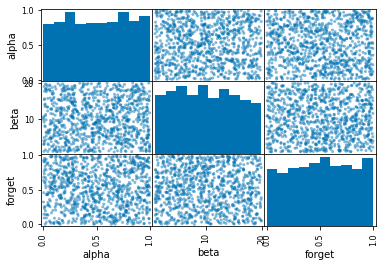

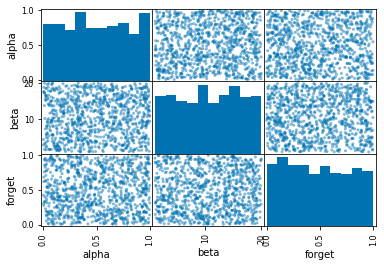

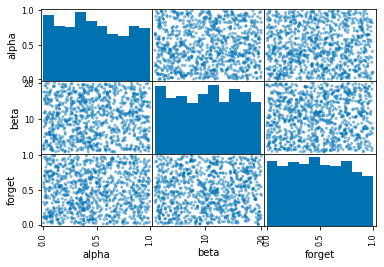

In [13]:
# Plot correlations and histograms
for model_name in models:
    model_summaries = all_summaries.loc[all_summaries['model'] == model_name]
    model_summaries = model_summaries.reset_index(drop=True)
    pd.plotting.scatter_matrix(model_summaries.loc[:1000, ['alpha', 'beta', 'forget']])

In [14]:
# Reusable histogram function for all histogram plots
def make_histogram(sim_dat, hum_dat, columns,
                   xlabels=False, ylabel="Density", xlim=False, ylim=False, vline=False, yscale_log=False, scale_data=1, plot_name=''):
    
    nrows = max(len(columns), 2)
    fig, axes = plt.subplots(nrows=nrows, figsize=(6, nrows * 2))
    [ax.set_ylabel(ylabel) for ax in axes]
    
    if not xlabels:
        xlabels = columns
    
    for i, (effect, xlabel) in enumerate(zip(columns, xlabels)):
        for model in models:
            dat = sim_dat.loc[sim_dat['model'] == model]
            sns.distplot(scale_data*dat[effect], kde=True, hist=False, label=model, ax=axes[i], bins=19)
        if np.any(hum_dat):
            axes[i].axvline(x=scale_data*hum_dat[effect].values, color='m', linestyle='-')
        axes[i].set_xlabel(xlabel)
    
    if vline:
        [ax.axvline(x=vline, color='grey', linestyle='--') for ax in axes]
    if xlim:
        [ax.set_xlim(xlim) for ax in axes]
    if ylim:
        [ax.set_ylim(ylim) for ax in axes]
    if yscale_log:
        [ax.set_yscale('log') for ax in axes]
    
    plt.legend()
    plt.tight_layout()
    figure_path = os.path.join(plot_save_dir, plot_name)
    plt.savefig(figure_path)
    print("Saved figure to {}".format(figure_path))

def get_means_sds(sim_dat, hum_dat, column, t_compare_value=0):
    
    means_sds = sim_dat.groupby("model")[column].agg(
        {'mean': 'mean',
         'std': 'std',
         'lik': lambda x: np.mean(x > hum_dat[column][0]),
         'lik2': lambda x: np.mean(x < hum_dat[column][0])})
    
    ttests = sim_dat.groupby('model')[column].agg(stats.ttest_1samp, t_compare_value)
    
    return means_sds, ttests

Saved figure to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\plots\0TS_react_hist.png
Saved figure to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\plots\0TS_react_hist_log.png


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



(           mean       std       lik      lik2
 model                                        
 Bayes  0.009323  0.067150  0.031050  0.968950
 flat   0.000208  0.065225  0.020342  0.979658
 hier   0.031629  0.080892  0.068248  0.931752, model
 Bayes                    (48.29522967613977, 0.0)
 flat     (1.1026381309236768, 0.2701865556422967)
 hier                    (136.01124242941134, 0.0)
 Name: CL_slope, dtype: object)

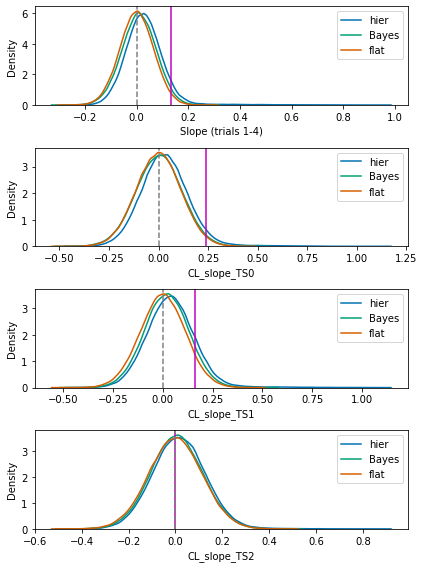

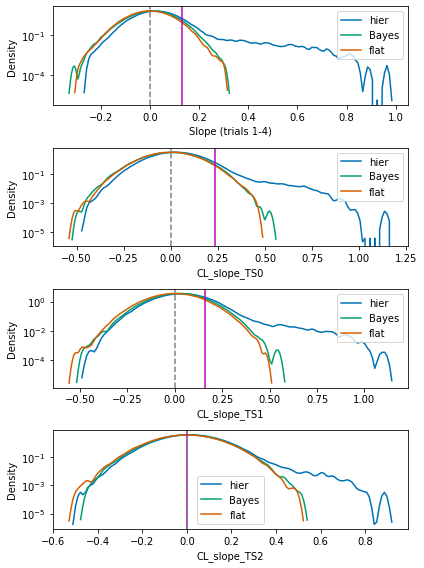

In [15]:
# Reactivation of TS (cloudy)
make_histogram(all_summaries, hum_summary_cloudy, CL_cols[8:],
               plot_name='0TS_react_hist.png',
               xlabels=['Slope (trials 1-4)'] + CL_cols[9:], vline=1e-10, yscale_log=False)
make_histogram(all_summaries, hum_summary_cloudy, CL_cols[8:],
               plot_name='0TS_react_hist_log.png',
               xlabels=['Slope (trials 1-4)'] + CL_cols[9:], vline=1e-10, yscale_log=True)
get_means_sds(all_summaries, hum_summary_cloudy, 'CL_slope')

Saved figure to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\plots\1intrusion_errors_hist.png
(           mean       std       lik      lik2
model                                        
Bayes  0.315474  0.037829  0.638851  0.361149
flat   0.355284  0.092753  0.838058  0.161942
hier   0.307599  0.041434  0.539025  0.460521, model
Bayes     (-164.2257199518745, 0.0)
flat       (81.97943161632857, 0.0)
hier     (-216.04445081351582, 0.0)
Name: IL_acc_current_TS, dtype: object)
(           mean       std       lik      lik2
model                                        
Bayes  0.414845  0.106085  0.446140  0.553860
flat   0.329652  0.036697  0.038317  0.961683
hier   0.443977  0.095973  0.634091  0.365752, model
Bayes                        (267.27271224133335, 0.0)
flat     (-34.754848260637274, 2.409977298461566e-263)
hier                         (401.02299779627816, 0.0)
Name: IL_acc_prev_TS, dtype: object)


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



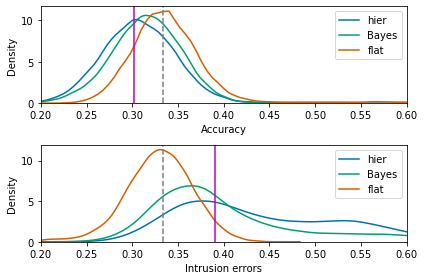

In [16]:
# Intrusion errors (init. learn.)
sub_dat = all_summaries.loc[(all_summaries.index % 5) == 4]
make_histogram(sub_dat, hum_summary_initial_learn, IL_cols[3:5],
               plot_name='1intrusion_errors_hist.png',
               xlim=(0.2, 0.6), xlabels=['Accuracy', 'Intrusion errors'], vline=1/3)
print(get_means_sds(all_summaries, hum_summary_initial_learn, IL_cols[3], 1/3))
print(get_means_sds(all_summaries, hum_summary_initial_learn, IL_cols[4], 1/3))

No handles with labels found to put in legend.


Saved figure to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\plots\2TS_values_perf_hist.png
(           mean       std       lik      lik2
model                                        
Bayes  0.007582  0.025545  0.483909  0.516091
flat  -0.000849  0.015855  0.369883  0.630117
hier  -0.009068  0.026617  0.289000  0.710983, model
Bayes                        (103.2448502668131, 0.0)
flat     (-18.54649693032395, 1.1148159993142747e-76)
hier                       (-118.50969912067185, 0.0)
Name: IL_perf_TS2minus1, dtype: object)


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

No handles with labels found to put in legend.


Saved figure to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\plots\2TS_values_perf_hist2.png
Saved figure to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\plots\2TS_values_perf_hist3.png


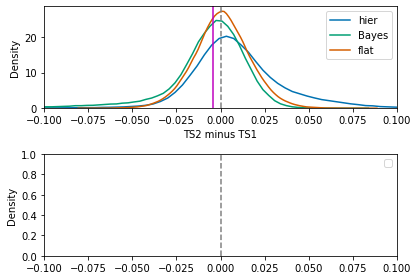

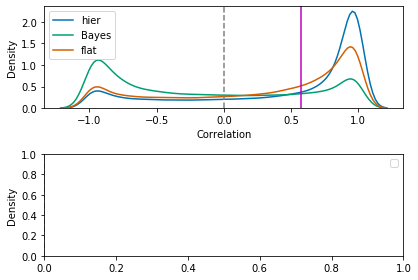

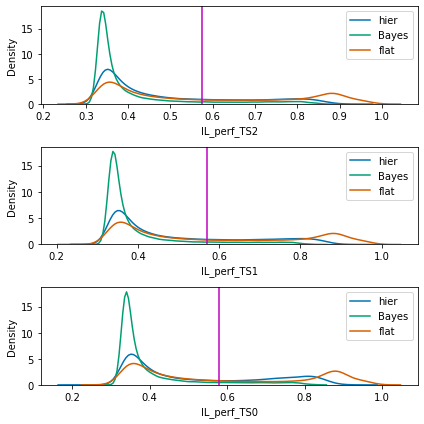

In [17]:
# TS values affect performance (init. learn.)
make_histogram(all_summaries, hum_summary_initial_learn, ['IL_perf_TS2minus1'],
               plot_name='2TS_values_perf_hist.png',
               xlim=(-0.1, 0.1), xlabels=['TS2 minus TS1'], vline=1e-10, scale_data=-1)
print(get_means_sds(all_summaries, hum_summary_initial_learn, 'IL_perf_TS2minus1'))
make_histogram(all_summaries, hum_summary_initial_learn, [IL_cols[-1]],
               plot_name='2TS_values_perf_hist2.png',
               xlabels=['Correlation'], vline=1e-10, scale_data=-1)
make_histogram(all_summaries, hum_summary_initial_learn, IL_cols[9:12][::-1], plot_name='2TS_values_perf_hist3.png')  # TS perf (init. learn.)

Saved figure to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\plots\3TS_values_preference_hist.png


No handles with labels found to put in legend.


Saved figure to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\plots\3TS_values_preference_hist2.png


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



(           mean       std       lik      lik2
 model                                        
 Bayes  0.039691  0.039163  0.255215  0.744785
 flat  -0.045869  0.066576  0.008017  0.991983
 hier   0.044209  0.044473  0.284050  0.715950, model
 Bayes      (352.5410950142298, 0.0)
 flat     (-238.66719584548878, 0.0)
 hier       (345.7877892128584, 0.0)
 Name: CO_season_minus_alien, dtype: object)

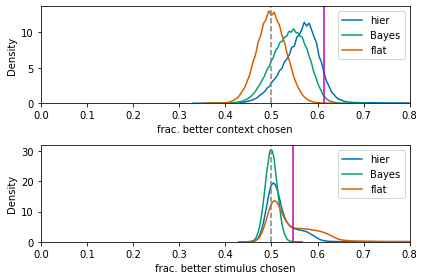

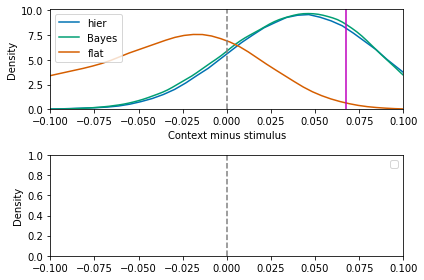

In [18]:
# TS values affect preference (competition)
make_histogram(all_summaries, hum_summary_competition, CO_cols[:2],
               plot_name='3TS_values_preference_hist.png',
               xlim=(0, 0.8), xlabels=['frac. better context chosen', 'frac. better stimulus chosen'], vline=1/2)
make_histogram(all_summaries, hum_summary_competition, ['CO_season_minus_alien'],
               plot_name='3TS_values_preference_hist2.png',
               xlim=(-0.1, 0.1), xlabels=['Context minus stimulus'], vline=1e-10)
get_means_sds(all_summaries, hum_summary_competition, 'CO_season_minus_alien')

No handles with labels found to put in legend.


Saved figure to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\plots\4TS_values_generalization_hist.png


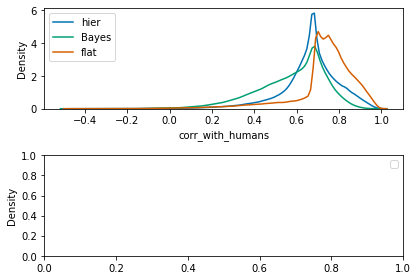

In [19]:
# TS values affect generalization (rainbow)
summary_rainbow['TS2minusTS0'] = summary_rainbow['TS2'] - summary_rainbow['TS0']
make_histogram(summary_rainbow, hum_dat=False, columns=['corr_with_humans'],
               plot_name='4TS_values_generalization_hist.png')
# make_histogram(summary_rainbow, hum_dat=hum_summary_rainbow, columns=['TS2minusTS0'],
#                plot_name='4TS_values_generalization_hist_.png')
# get_means_sds(summary_rainbow, hum_summary_rainbow, 'TS2minusTS0')

Saved figure to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\plots\5Savings_hist.png


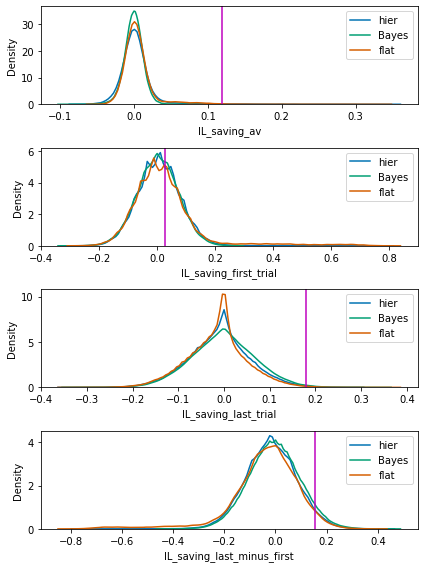

In [20]:
# Savings (init. learn.)
make_histogram(all_summaries,
               hum_summary_initial_learn, IL_cols[:3] + ['IL_saving_last_minus_first'],
               plot_name='5Savings_hist.png')

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



(           mean       std       lik      lik2
 model                                        
 Bayes -0.042927  0.064265  0.803000  0.197000
 flat  -0.036993  0.041065  0.780300  0.219700
 hier  -0.131192  0.107032  0.417901  0.582099, model
 Bayes    (-232.35223548995114, 0.0)
 flat     (-312.05961703277256, 0.0)
 hier     (-426.37108386085765, 0.0)
 Name: TS2minusTS0, dtype: object)

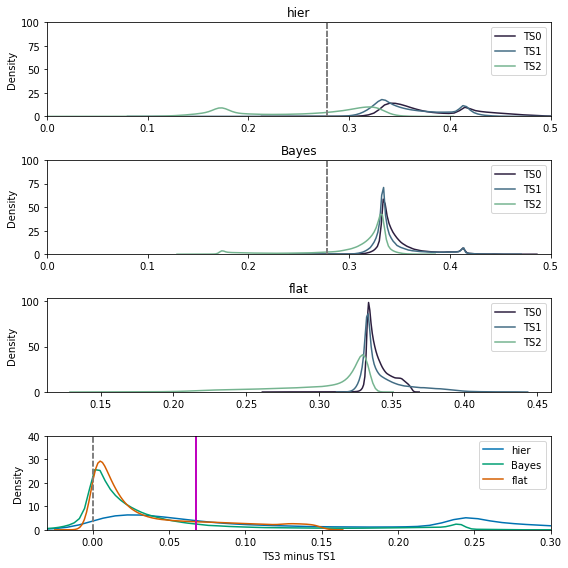

In [21]:
# TS values affect generalization (rainbow)
fig, axes = plt.subplots(nrows=len(models) + 1, figsize=(8, 8))
colors = sns.cubehelix_palette(4, start=.5, rot=-.75, reverse=True)[:-1]

for i, model in enumerate(models):
    dat = summary_rainbow.loc[summary_rainbow['model'] == model]

    # Plot
    for j, effect in enumerate(RB_sum_cols[:3]):
        sns.distplot(dat[effect], kde=True, hist=False, label=effect, color=colors[j], ax=axes[i])
        [ax.axvline(x=10/12/3, color='grey', linestyle='--') for ax in axes[:2]]
        [ax.set_xlim(0, 0.5) for ax in axes[:2]]
        [ax.set_ylim(0, 100) for ax in axes[:2]]
        axes[i].set_title(model)
        [ax.set_xlabel("") for ax in axes]
        axes[i].legend()

    effect = 'TS2minusTS0'
    sns.distplot(-dat[effect], kde=True, hist=False, label=model, ax=axes[-1])
    axes[-1].axvline(x=0, color='grey', linestyle='--')
    axes[-1].axvline(x=-hum_summary_rainbow[effect].values, color='m', linestyle='-')
    axes[-1].set_xlim(-0.03, 0.3)
    axes[-1].set_ylim(0, 40)
    axes[-1].set_xlabel("TS3 minus TS1")
    axes[-1].legend()
[ax.set_ylabel("Density") for ax in axes]
plt.tight_layout()
plt.savefig(plot_save_dir + '/4TS_values_generalization_hist2.png')
get_means_sds(summary_rainbow, hum_summary_rainbow, 'TS2minusTS0')

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous ax

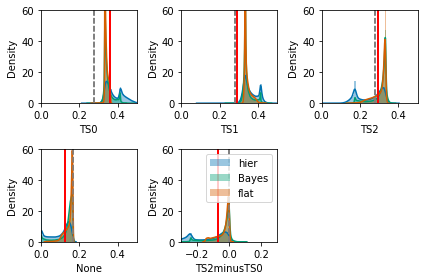

In [22]:
# Rainbow phase TS choices
plt.figure()
for model in models:

    # Get summary_rainbow
    rainbow_dat = all_summaries.loc[all_summaries['model'] == model, RB_cols]
    rainbow_dat = rainbow_dat.values.reshape((rainbow_dat.shape[0], n_aliens, n_actions))
    summary_rainbow = np.array([get_summary_rainbow(n_aliens, n_seasons, dat, task) for dat in rainbow_dat])
    summary_rainbow = pd.DataFrame(summary_rainbow, columns=RB_sum_cols)

    # Plot
    for i, effect in enumerate(RB_sum_cols[:3]):
        plt.subplot(2, 3, i+1)
        sns.distplot(summary_rainbow[effect], kde=True, hist=True, label=model)
        plt.axvline(x=10/12/3, color='grey', linestyle='--')
        plt.axvline(x=hum_summary_rainbow[effect].values, color='red', linestyle='-')
        plt.xlim(0, 0.5)
        plt.ylim(0, 60)
        plt.xlabel(effect)
        plt.ylabel("Density")

    effect = RB_sum_cols[3]
    plt.subplot(2, 3, 4)
    sns.distplot(summary_rainbow[effect], kde=True, hist=True, label=model)
    plt.axvline(x=(2/12), color='grey', linestyle='--')
    plt.axvline(x=hum_summary_rainbow[effect].values, color='red', linestyle='-')
    plt.xlim(0, 0.5)
    plt.ylim(0, 60)
    plt.xlabel(effect)
    plt.ylabel("Density")

    effect = 'TS2minusTS0'
    plt.subplot(2, 3, 5)
    sns.distplot(summary_rainbow[effect], kde=True, hist=True, label=model)
    plt.axvline(x=0, color='grey', linestyle='--')
    plt.axvline(x=hum_summary_rainbow[effect].values, color='red', linestyle='-')
    plt.xlim(-0.3, 0.3)
    plt.ylim(0, 60)
    plt.xlabel(effect)
    plt.ylabel("Density")

plt.legend()
plt.tight_layout()

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


TypeError: '<=' not supported between instances of 'float' and 'str'

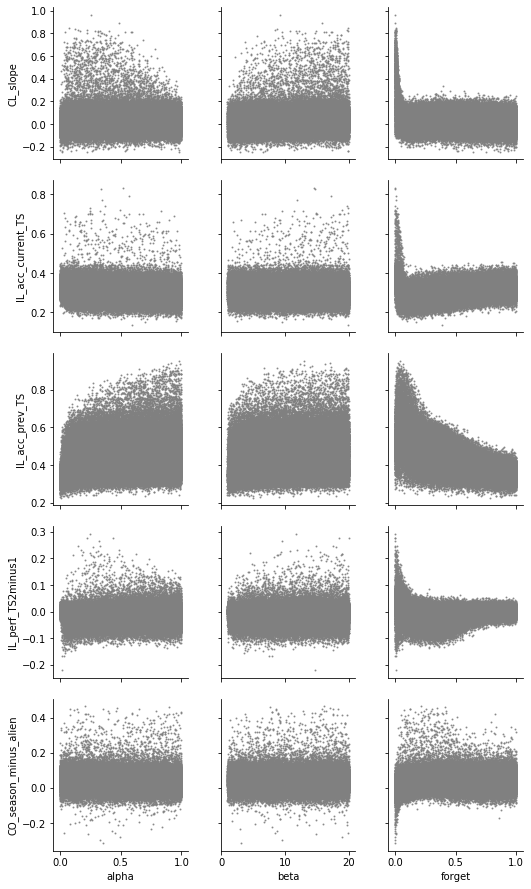

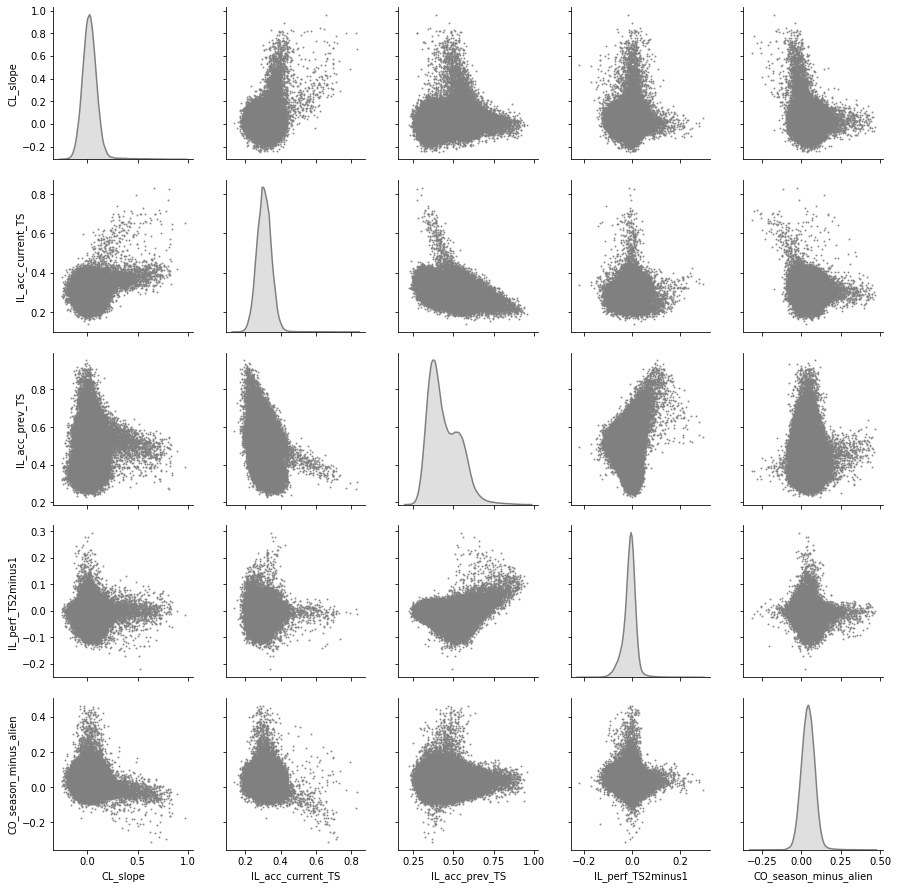

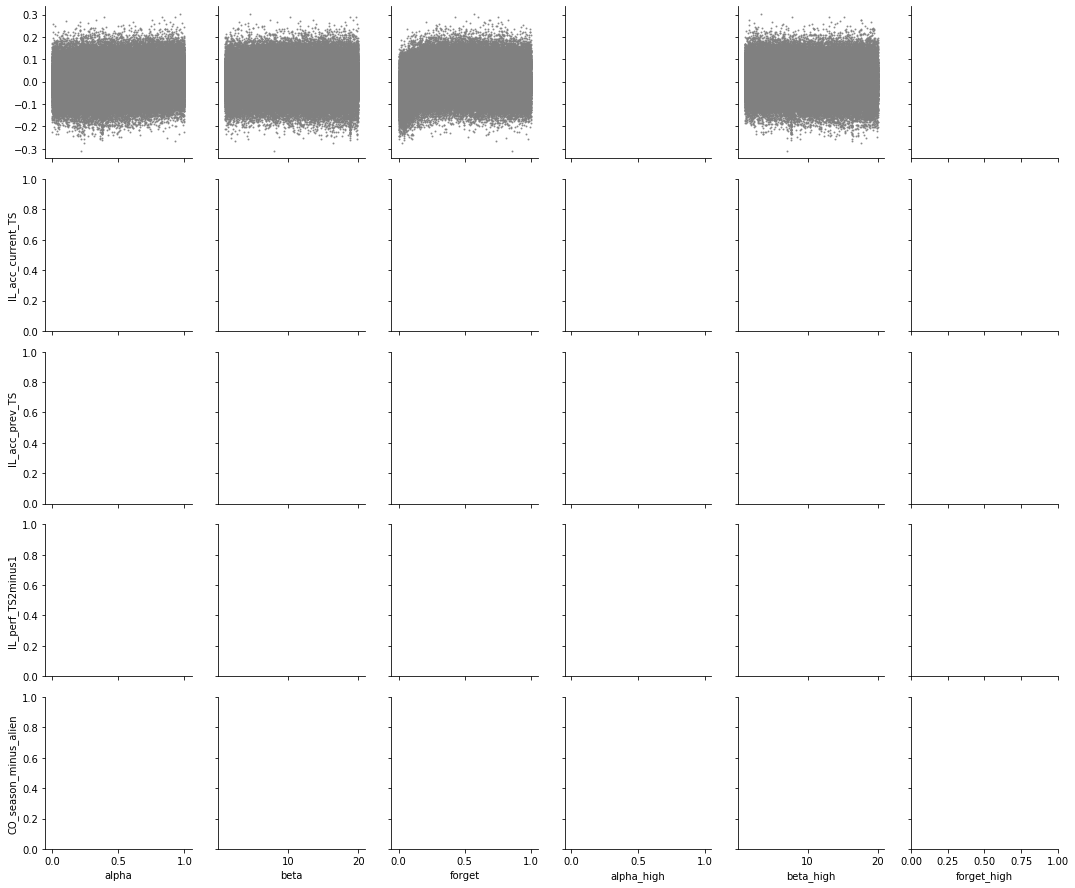

In [23]:
# Plot paramter - marker correlations
hum_sums = hum_summary_initial_learn[['IL_acc_prev_TS', 'IL_acc_current_TS', 'IL_perf_TS2minus1']]
hum_sums['CL_slope'] = hum_summary_cloudy['CL_slope']
hum_sums['CO_season_minus_alien'] = hum_summary_competition['CO_season_minus_alien']
markers = ['CL_slope', 'IL_acc_current_TS', 'IL_acc_prev_TS', 'IL_perf_TS2minus1', 'CO_season_minus_alien']

for model, params in zip(models, [param_names[:3], param_names]):

    # Correlations between markers and parameters
    dat = all_summaries.loc[all_summaries['model'] == model]
    sns.pairplot(dat, x_vars=params, y_vars=markers, kind='reg',
             plot_kws={'color': 'grey', 'fit_reg': False, 'scatter_kws': {'s': 1}})
    plt.savefig(plot_save_dir + '/CorrMarkerParam_' + model + '.png')

    # Correlations between different markers
    sns.pairplot(dat, vars=markers, kind='reg',
                 plot_kws={'color': 'grey', 'fit_reg': False, 'scatter_kws': {'s': 1}},
                 diag_kind='kde', diag_kws={'color': 'grey', 'shade': True})
    # add human data
    # plt.scatter(hum_sums)
    plt.savefig(plot_save_dir + '/CorrParamParam_' + model + '.png')

In [26]:
all_summaries.columns

Index(['CL_acc_trial0', 'CL_acc_trial0_se', 'CL_acc_trial1',
       'CL_acc_trial1_se', 'CL_acc_trial2', 'CL_acc_trial2_se',
       'CL_acc_trial3', 'CL_acc_trial3_se', 'CL_slope', 'CL_slope_TS0',
       'CL_slope_TS1', 'CL_slope_TS2', 'CO_acc_season', 'CO_acc_season_alien',
       'CO_acc_season_alien_se', 'CO_acc_season_se', 'IL_acc_current_TS',
       'IL_acc_current_TS_se', 'IL_acc_other_TS', 'IL_acc_other_TS_se',
       'IL_acc_prev_TS', 'IL_acc_prev_TS_se', 'IL_perf_TS0', 'IL_perf_TS0_se',
       'IL_perf_TS1', 'IL_perf_TS1_se', 'IL_perf_TS2', 'IL_perf_TS2_se',
       'IL_perf_TS_corr', 'IL_saving_av', 'IL_saving_first_trial',
       'IL_saving_last_trial', 'RB_alien0_action0', 'RB_alien0_action1',
       'RB_alien0_action2', 'RB_alien1_action0', 'RB_alien1_action1',
       'RB_alien1_action2', 'RB_alien2_action0', 'RB_alien2_action1',
       'RB_alien2_action2', 'RB_alien3_action0', 'RB_alien3_action1',
       'RB_alien3_action2', 'alpha', 'alpha_high', 'beta', 'beta_high',
    

Found 420 agents: ['hier', 'Bayes', 'flat'], [196, 219, 5]
Saving selected_agents to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision/selected_agents.csv


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


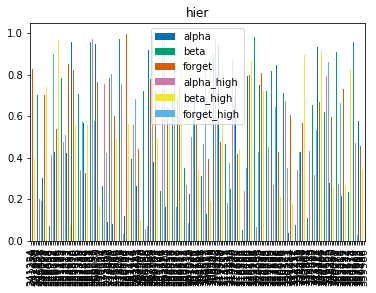

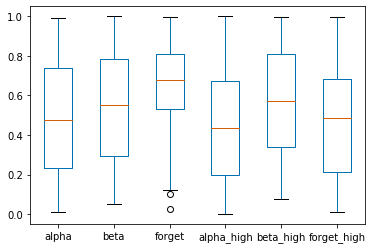

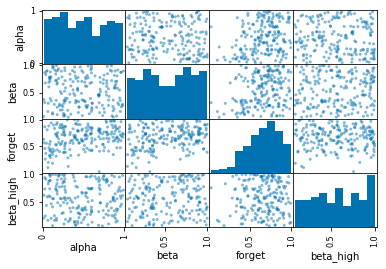

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


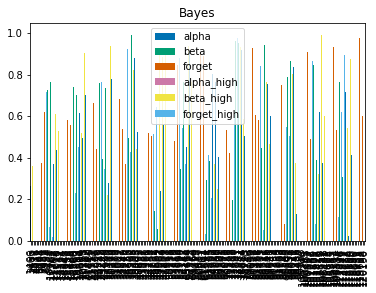

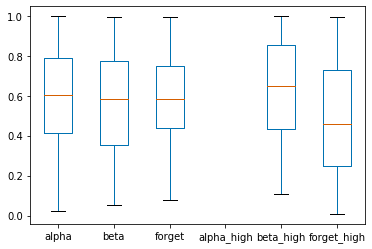

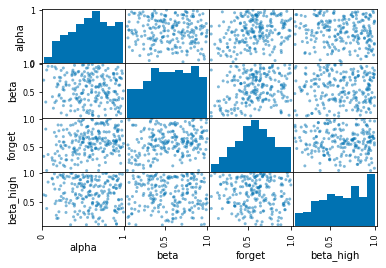

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


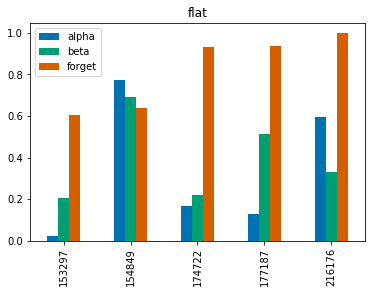

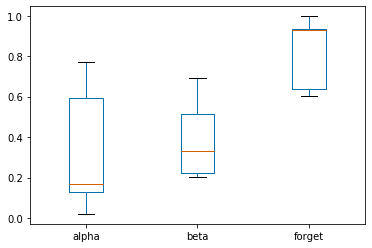

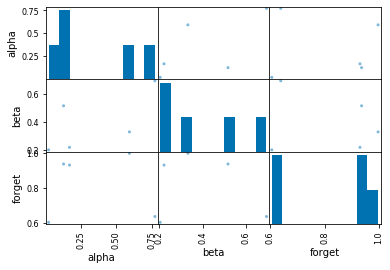

In [27]:
# Find a good subset of parameters - define criteria
lower, upper = 9/10, 11/10
IL_acc_prev_TS = (
        all_summaries['IL_acc_prev_TS'] > lower * hum_summary_initial_learn['IL_acc_prev_TS'].values[0]) & (
        all_summaries['IL_acc_prev_TS'] < upper * hum_summary_initial_learn['IL_acc_prev_TS'].values[0])
CL_slope = (
        all_summaries['CL_slope'] > lower * hum_summary_cloudy['CL_slope'].values[0]) & (
        all_summaries['CL_slope'] < upper * hum_summary_cloudy['CL_slope'].values[0])
CO_season_minus_alien = (
       all_summaries['CO_season_minus_alien'] > lower * hum_summary_competition['CO_season_minus_alien'].values[0]) & (
       all_summaries['CO_season_minus_alien'] < upper * hum_summary_competition['CO_season_minus_alien'].values[0])
IL_perf_TS2minus1 = (
        all_summaries['IL_perf_TS2minus1'] < lower * hum_summary_initial_learn['IL_perf_TS2minus1'].values[0]) & (
        all_summaries['IL_perf_TS2minus1'] > upper * hum_summary_initial_learn['IL_perf_TS2minus1'].values[0])
# RB_TS2minusTS0 = rainbow_dat['TS2minutsTS0']

# Subset data and plot
selected_agents = all_summaries.loc[IL_acc_prev_TS & CL_slope & CO_season_minus_alien]  # IL_acc_prev_TS & CL_slope & CO_season_minus_alien & IL_perf_TS2minus1

model_ns = [selected_agents.loc[selected_agents['model'] == model,].shape[0] for model in models]
print("Found {} agents: {}, {}".format(selected_agents.shape[0], models, model_ns))

# Save selected_agents as csv
if do_save_selected_agents:
    save_path = summary_save_dir + '/selected_agents.csv'
    print("Saving selected_agents to {}".format(save_path))
    selected_agents.to_csv(save_path, index=False)

for model in models:
    sub_dat = selected_agents.loc[selected_agents['model'] == model]
    sub_dat[['beta', 'beta_high']] /= 20
    if model == 'flat':
        param_names_ = param_names[:3]
    else:
        param_names_ = param_names
    sub_dat[param_names_].plot(kind='bar', title=model)
    sub_dat[param_names_].plot(kind='box', by='model')
    scatter_matrix(sub_dat[param_names_])
    plt.show()
    
# Nice looking agent: selected_agents.loc[129534, param_names]

In [28]:
# Intrusion error heatmap (prev_TS)
fig = plt.figure(figsize=(10, 5))
for i, effect in enumerate(['IL_acc_prev_TS', 'IL_acc_current_TS']):

    # Subset data with human-like behavior
    dat = all_summaries.loc[(all_summaries['model'] == 'hier') &
                            (all_summaries['IL_acc_prev_TS'] > 0.55)]

    # Plot raw parameters
    ax = fig.add_subplot(2, 3, (i*3)+1, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha'], dat['beta'], dat['forget'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha')
    ax.set_ylabel('beta')
    ax.set_zlabel('forget')

    ax = fig.add_subplot(2, 3, (i*3)+2, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha_high'], dat['beta_high'], dat['forget_high'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha_high')
    ax.set_ylabel('beta_high')
    ax.set_zlabel('forget_high')

    if do_isomap:
        # Dimensionality reduction
        n_neighbors = 12
        n_components = 3
        params_norm = preprocessing.StandardScaler().fit_transform(dat[param_names])  # standardize data
        Y = manifold.Isomap(n_neighbors, n_components).fit_transform(params_norm)  # apply Isomap

        # Plot dimensionality-reduced parameters
        ax = fig.add_subplot(2, 3, (i*3)+3, projection='3d')
        ax.set_title("Isomap " + effect)
        ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=dat[effect], marker='.')

    plt.tight_layout()
plt.show()

ValueError: Invalid RGBA argument: masked_array(data=[0.277941, 0.056324, 0.381191, 0.5451301141641658],
             mask=False,
       fill_value='?',
            dtype=object)

<Figure size 720x360 with 4 Axes>

In [ ]:
# # Calculate Isomap & Co. and visualize
# params_norm = preprocessing.StandardScaler().fit_transform(dat[param_names])  # standardize data
# effect = dat['IL_acc_prev_TS']
# fig = plt.figure(figsize=(15, 5))
#
# i = 1
# for n_components in range(2, 6, 2):
#     for n_neighbors in range(2, 20, 3):
#
#         # Reduce dimensionality
#         # Y = decomposition.PCA(n_components).fit_transform(params_norm)
#         # mds = manifold.MDS(n_neighbors, max_iter=100, n_init=1)
#         # Y = mds.fit_transform(params_norm)
#         # Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components, eigen_solver='auto',
#         #                                     method='standard').fit_transform(params_norm)
#         # Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components, eigen_solver='auto',  # n_neighbors >= 6
#         #                                     method='modified').fit_transform(params_norm)
#         Y = manifold.Isomap(n_neighbors, n_components).fit_transform(params_norm)
#
#         # Plot
#         ax = fig.add_subplot(2, 6, i)
#         plt.scatter(Y[:, 0], Y[:, 1], c=effect)
#         plt.title('{0} comp., {1} neigh.'.format(n_components, n_neighbors))
#         i += 1
# plt.tight_layout()
# plt.show()

# Intrusion error heatmap (other TS)
fig = plt.figure()
for i, effect in enumerate(['IL_acc_other_TS', 'IL_acc_current_TS']):

    dat = all_summaries.loc[(all_summaries['model'] == 'hier') &
                            (all_summaries['IL_acc_other_TS'] > 1/3)]

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha'], dat['beta'], dat['forget'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha')
    ax.set_ylabel('beta')
    ax.set_zlabel('forget')

    ax = fig.add_subplot(2, 2, i+3, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha_high'], dat['beta_high'], dat['forget_high'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha_high')
    ax.set_ylabel('beta_high')
    ax.set_zlabel('forget_high')
plt.tight_layout()

# Savings heatmap
fig = plt.figure()
for i, effect in enumerate(['IL_saving_av', 'IL_saving_first_trial', 'IL_saving_last_trial', 'IL_saving_last_minus_first']):

    dat = all_summaries.loc[(all_summaries['model'] == 'hier') &
                            (all_summaries['IL_saving_last_trial'] > 0.01) & (all_summaries['IL_saving_first_trial'] > 0.08)]

    ax = fig.add_subplot(2, 4, i+1, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha'], dat['beta'], dat['forget'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha')
    ax.set_ylabel('beta')
    ax.set_zlabel('forget')

    ax = fig.add_subplot(2, 4, i+5, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha_high'], dat['beta_high'], dat['forget_high'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha_high')
    ax.set_ylabel('beta_high')
    ax.set_zlabel('forget_high')
plt.tight_layout()

# Cloudy heatmap
fig = plt.figure()
for i, effect in enumerate(['CL_acc_trial2', 'CL_acc_trial3']):

    dat = all_summaries.loc[(all_summaries['model'] == 'hier') &
                            (all_summaries['CL_acc_trial2'] > 0.4) & (all_summaries['CL_acc_trial3'] > 0.4)]

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha'], dat['beta'], dat['forget'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha')
    ax.set_ylabel('beta')
    ax.set_zlabel('forget')

    ax = fig.add_subplot(2, 2, i+3, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha_high'], dat['beta_high'], dat['forget_high'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha_high')
    ax.set_ylabel('beta_high')
    ax.set_zlabel('forget_high')
plt.tight_layout()

# Competition heatmap
fig = plt.figure()
for i, effect in enumerate(['CO_acc_season', 'CO_acc_season_alien']):

    dat = all_summaries.loc[(all_summaries['model'] == 'hier') &
                            (all_summaries['CO_acc_season'] > 0.65)]  #  &(all_summaries['CO_acc_season_alien'] > 0.60)

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha'], dat['beta'], dat['forget'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha')
    ax.set_ylabel('beta')
    ax.set_zlabel('forget')

    ax = fig.add_subplot(2, 2, i+3, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha_high'], dat['beta_high'], dat['forget_high'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha_high')
    ax.set_ylabel('beta_high')
    ax.set_zlabel('forget_high')
plt.tight_layout()

# Rainbow heatmap
fig = plt.figure()
for i, effect in enumerate(['RB_choices_TS0', 'RB_choices_TS1', 'RB_choices_TS2']):

    dat = all_summaries.loc[(all_summaries['model'] == 'hier') &
                            (all_summaries['RB_choices_TS0'] > 1300) & (all_summaries['RB_choices_TS1'] > 1000)]

    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha'], dat['beta'], dat['forget'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha')
    ax.set_ylabel('beta')
    ax.set_zlabel('forget')

    ax = fig.add_subplot(2, 3, i+4, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha_high'], dat['beta_high'], dat['forget_high'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha_high')
    ax.set_ylabel('beta_high')
    ax.set_zlabel('forget_high')
plt.tight_layout()

# Plot overall heatmaps -> systematicity between parameters & effects?
for effect in summary_dat_cols:
    fig = plt.figure()
    plt.title(effect)
    for i, model in enumerate(models):
        dat = all_summaries.loc[all_summaries['model'] == model][:1000].copy()

        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        ax.scatter(dat['alpha'], dat['beta'], dat['forget'], c=dat[effect], label=dat[effect], marker='.')
        ax.set_title(model)
        ax.set_xlabel('alpha')
        ax.set_ylabel('beta')
        ax.set_zlabel('forget')

        ax = fig.add_subplot(2, 2, i+3, projection='3d')
        ax.scatter(dat['alpha_high'], dat['beta_high'], dat['forget_high'], c=dat[effect], label=dat[effect], marker='.')
        ax.set_xlabel('alpha_high')
        ax.set_ylabel('beta_high')
        ax.set_zlabel('forget_high')
    plt.tight_layout()

# Plot average effects for hierarchical and flat
fig = plt.figure()
ax = fig.add_subplot(111)

for i, model in enumerate(models):
    dat = all_summaries.loc[all_summaries['model'] == model].copy()
    RB_effects = [effect for effect in all_summaries.columns.values if 'RB' in effect]

    dat[RB_effects] /= 1000
    dat['beta'] /= 10
    x = np.arange(len(summary_dat_cols)) + 0.2 * (2*i-1)
    y = np.mean(dat[summary_dat_cols], axis=0)
    yerr = np.std(dat[summary_dat_cols], axis=0) / np.sqrt(len(summary_dat_cols))

    ax.bar(x, y.values, 0.4, yerr=yerr, label=model)
ax.set_xticks(np.arange(len(summary_dat_cols)))
ax.set_xticklabels(summary_dat_cols)
plt.xticks(rotation=20)
plt.ylabel('Effect (RB /= 1000)')
plt.legend()

## Plot bar graphs for humans and agents

In [29]:
# Plot human behavior & selected_agents
def make_plot(hum_mean, ag_mean, hum_se=False, ag_se=False, plot_name="plot.png", ylabel="",
              hline=False, ylim=False, xlabel="", xticklabels=False, figsize=(8,4)):

    if not np.any(hum_se):
        hum_se = np.zeros(len(hum_mean.T))
    if not np.any(ag_se):
        ag_se = np.zeros(3)
    if not xticklabels:
        xticklabels = ""

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=figsize)
    [ax.set_title(title) for ax, title in zip(axes, ['Humans'] + models)]

    axes[0].bar(range(len(hum_mean)), hum_mean, yerr=hum_se, tick_label=xticklabels, color='grey')
    for i_model in range(len(models)):
        axes[i_model+1].bar(range(len(hum_mean)), ag_mean[i_model], yerr=ag_se[i_model],
                          tick_label=xticklabels, color='grey')

    [ax.set_ylabel(ylabel) for ax in axes]
    [ax.set_xlabel(xlabel) for ax in axes]

    if ylim:
        [ax.set_ylim(ylim) for ax in axes]
    if hline:
        [ax.axhline(y=hline, color='black', linestyle='--') for ax in axes]

    plt.tight_layout()
    plt.savefig(plot_save_dir + plot_name)

In [44]:
# Get agent data
model_idx = 2
selected_agents = pd.read_csv(summary_save_dir + '/selected_agents.csv', index_col=0)
selected_agents = selected_agents.reset_index()
# ag_summary = selected_agents.loc[selected_agents['model'] == 'flat']  # 0, 5, 6
ag_summary = pd.DataFrame(
    [selected_agents.loc[selected_agents['model'] == model
                        ].reset_index(drop=True).loc[min(model_ns[i]-1, model_idx)]
     for i, model in enumerate(models)]
    )

save_dir = summary_save_dir + 'ag_summary_for_paper.csv'
ag_summary.to_csv(save_dir)
print("Saving agents used for paper plots to {}!".format(save_dir))
ag_summary

Saving agents used for paper plots to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revisionag_summary_for_paper.csv!


,CL_acc_trial0,CL_acc_trial0_se,CL_acc_trial1,CL_acc_trial1_se,CL_acc_trial2,CL_acc_trial2_se,CL_acc_trial3,CL_acc_trial3_se,CL_slope,CL_slope_TS0,...,alpha,alpha_high,beta,beta_high,forget,forget_high,model,IL_saving_last_minus_first,IL_perf_TS2minus1,CO_season_minus_alien
2,0.279693,0.027426,0.318008,0.028011,0.337165,0.023295,0.356322,0.034002,0.124521,0.149425,...,0.329883,0.715847,6.567524,7.841080,0.437956,0.961770,hier,0.000000,-0.006631,0.063331
2,0.249042,0.032355,0.264368,0.021273,0.314176,0.028707,0.314176,0.028707,0.122605,0.022989,...,0.509810,NaN,14.523506,6.397563,0.647158,0.209594,Bayes,-0.068966,-0.003316,0.066036
2,0.321839,0.029848,0.310345,0.030353,0.390805,0.028477,0.379310,0.031834,0.126437,0.287356,...,0.168003,NaN,4.423104,NaN,0.930603,NaN,flat,0.114943,0.000000,0.063556


In [45]:
ag_summary_rainbow = pd.DataFrame()
ag_rainbow_dat = list()

for model in models:
    model_dat = ag_summary.loc[ag_summary['model'] == model, RB_cols]
    mod_ag_rainbow_dat = model_dat.values.reshape((n_aliens, n_actions))
    mod_ag_summary_rainbow = get_summary_rainbow(n_aliens, n_seasons, mod_ag_rainbow_dat, task)
    mod_ag_summary_rainbow = pd.DataFrame(np.expand_dims(mod_ag_summary_rainbow, axis=0),
                                       columns=RB_sum_cols)
    mod_ag_summary_rainbow['TS2minusTS1'] = mod_ag_summary_rainbow['TS2'] - mod_ag_summary_rainbow['TS1']
    
    ag_summary_rainbow = ag_summary_rainbow.append(mod_ag_summary_rainbow)
    ag_rainbow_dat.append(mod_ag_rainbow_dat)
    
ag_summary_rainbow

,TS0,TS1,TS2,None,TS0_se,TS1_se,TS2_se,None_se,TS2minusTS0,TS2minusTS1
0,0.341661,0.401752,0.275959,0.127278,0.0,0.0,0.0,0.0,-0.065702,-0.125793
0,0.315610,0.340959,0.344894,0.142289,0.0,0.0,0.0,0.0,0.029284,0.003935
0,0.334997,0.332407,0.333619,0.165231,0.0,0.0,0.0,0.0,-0.001378,0.001212


In [46]:
# # Double-check selected hier-agent summary
# # summary_save_dir_ag = os.path.join(get_alien_paths(run_on_cluster)['fitting results'], 'SummariesInsteadOfFitting')  # Where will the simulated summary data be saved and read from?
# params = pd.read_csv(old_summary_save_dir + '/ag_summary_for_paper.csv', index_col=0).loc[param_names]
# params_01 = params.values.flatten() / (param_ranges.loc[1] - param_ranges.loc[0]) - param_ranges.loc[0] / (
#             param_ranges.loc[1] - param_ranges.loc[0])
# # params_back = param_ranges.loc[0] + (param_ranges.loc[1] - param_ranges.loc[0]) * params_01  # making sure i'm getting the right parameters back after transformation!

# summary = get_summary(params_01.values.flatten(), param_ranges, n_sim, n_subj)
# summary = pd.DataFrame(summary, index=summary_dat_cols).transpose()

# summary  # check that it agrees with what we have in the paper! (This is just to double-check that I'm using the right parameters for the simulations!

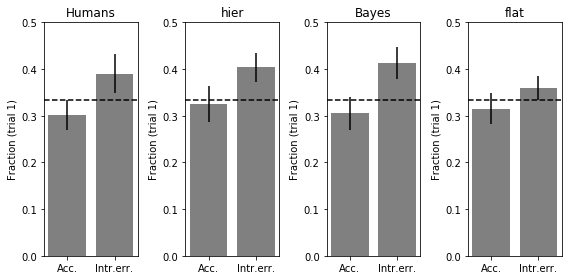

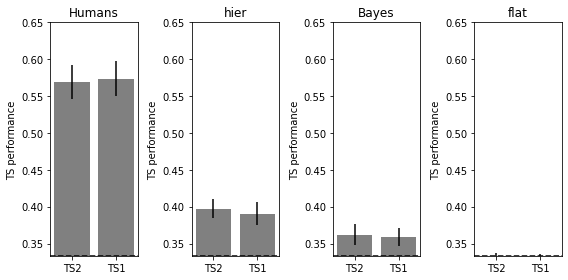

In [47]:
# Plot intrusion errors
make_plot(hum_summary_initial_learn[IL_cols[3:5]].values.flatten(), ag_summary[IL_cols[3:5]].values,
          hum_summary_initial_learn[IL_cols[6:8]].values.flatten(), ag_summary[IL_cols[6:8]].values,
          plot_name='1intrusion_errors_{}.png'.format(model_idx), figsize=(8, 4),
          ylabel="Fraction (trial 1)", hline=1/3, ylim=(0, 0.5), xticklabels=['Acc.', 'Intr.err.'])

# Plot TS values affect performance
make_plot(hum_summary_initial_learn[IL_cols[10:12]].values.flatten(), ag_summary[IL_cols[10:12]].values,
          hum_summary_initial_learn[IL_cols[13:15]].values.flatten(), ag_summary[IL_cols[13:15]].values,
          plot_name='2TS_values_perf_{}.png.'.format(model_idx), figsize=(8, 4),
          ylabel="TS performance", hline=1/3, ylim=(1/3, 0.65), xticklabels=['TS2', 'TS1'])

# # Plot Savings
# make_plot(hum_summary_initial_learn[IL_cols[:3]].values.flatten(), ag_summary[IL_cols[:3]].values,
#           plot_name='5Savings.png', figsize=(12, 4),
#           ylabel="Savings", xticklabels=IL_cols[:3])

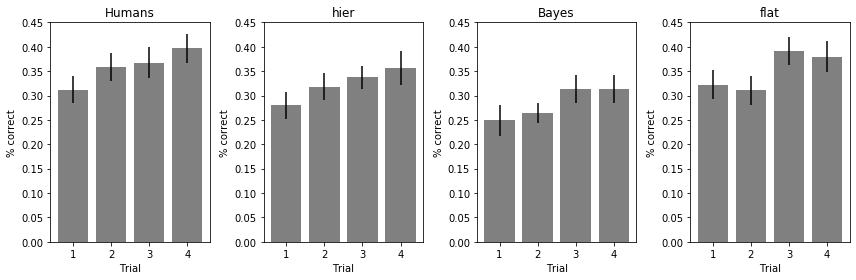

In [48]:
# Plot TS reactivation
make_plot(hum_summary_cloudy[CL_cols[:4]].values.flatten(), ag_summary[CL_cols[:4]].values,
          hum_summary_cloudy[CL_cols[4:8]].values.flatten(), ag_summary[CL_cols[4:8]].values,
          plot_name='0TS_react_{}.png'.format(model_idx), figsize=(12, 4),
          ylabel="% correct", hline=False, ylim=(0, 0.45),
          xlabel="Trial", xticklabels=range(1, n_aliens+1))

In [35]:
ag_summary.columns

Index(['CL_acc_trial0', 'CL_acc_trial0_se', 'CL_acc_trial1',
       'CL_acc_trial1_se', 'CL_acc_trial2', 'CL_acc_trial2_se',
       'CL_acc_trial3', 'CL_acc_trial3_se', 'CL_slope', 'CL_slope_TS0',
       'CL_slope_TS1', 'CL_slope_TS2', 'CO_acc_season', 'CO_acc_season_alien',
       'CO_acc_season_alien_se', 'CO_acc_season_se', 'IL_acc_current_TS',
       'IL_acc_current_TS_se', 'IL_acc_other_TS', 'IL_acc_other_TS_se',
       'IL_acc_prev_TS', 'IL_acc_prev_TS_se', 'IL_perf_TS0', 'IL_perf_TS0_se',
       'IL_perf_TS1', 'IL_perf_TS1_se', 'IL_perf_TS2', 'IL_perf_TS2_se',
       'IL_perf_TS_corr', 'IL_saving_av', 'IL_saving_first_trial',
       'IL_saving_last_trial', 'RB_alien0_action0', 'RB_alien0_action1',
       'RB_alien0_action2', 'RB_alien1_action0', 'RB_alien1_action1',
       'RB_alien1_action2', 'RB_alien2_action0', 'RB_alien2_action1',
       'RB_alien2_action2', 'RB_alien3_action0', 'RB_alien3_action1',
       'RB_alien3_action2', 'alpha', 'alpha_high', 'beta', 'beta_high',
    

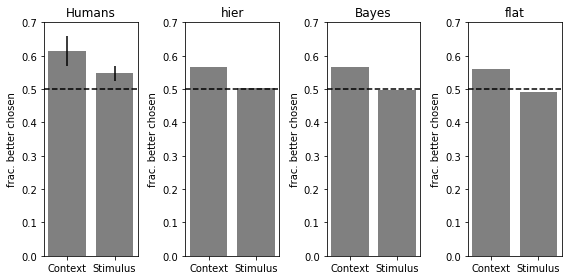

In [36]:
# TS values affect preference
make_plot(hum_summary_competition[CO_cols[:2]].values.flatten(), ag_summary[CO_cols[:2]].values,
          hum_summary_competition[CO_cols[2:4]].values.flatten(), #ag_summary[CO_cols[2:4]].values,
          plot_name='3TS_values_preference_{}.png'.format(model_idx), figsize=(8, 4),
          ylabel="frac. better chosen", hline=1/2, ylim=(0, 0.7), xticklabels=['Context', 'Stimulus'])

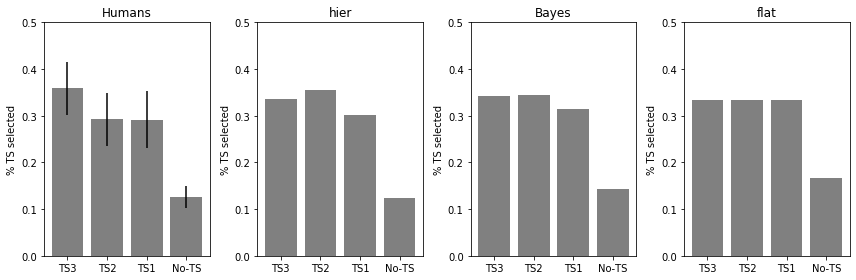

In [37]:
# Plot TS values affect generalization
make_plot(hum_summary_rainbow[RB_sum_cols[:4]].values.flatten(), ag_summary_rainbow[RB_sum_cols[:4]].values,
          hum_summary_rainbow[RB_sum_cols[4:8]].values.flatten(),
          plot_name='4TS_values_generalization_{}.png'.format(model_idx), figsize=(12, 4),
          ylabel='% TS selected', ylim=(0, 0.5), xticklabels=['TS3', 'TS2', 'TS1', 'No-TS'])

[Text(0, 0.5, 'Stimulus'),
 Text(0, 0.5, 'Stimulus'),
 Text(0, 0.5, 'Stimulus'),
 Text(0, 0.5, 'Stimulus')]

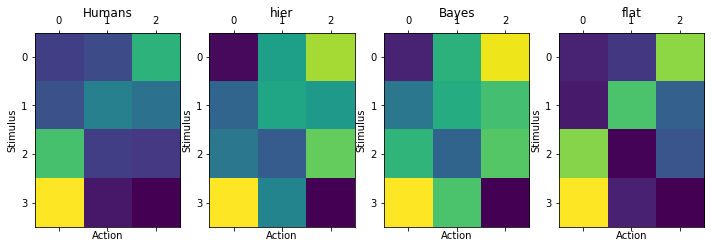

In [38]:
# # Rainbow phase correlation between human and simulated actions
# rb_cor = np.corrcoef(hum_rainbow_dat[0].flatten(), ag_rainbow_dat.astype(float).flatten())[0, 1]
# stats.pearsonr(hum_rainbow_dat[0].flatten(), ag_rainbow_dat.astype(float).flatten())

# Rainbow phase action heatmaps
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
# plt.suptitle('Correlation between humans & simulation: {}'.format(rb_cor.round(3)))
[ax.set_title(title) for ax, title in zip(axes, ['Humans'] + models)]
cax1 = axes[0].matshow(hum_rainbow_dat[0])
for i in range(len(models)):
    axes[i+1].matshow(pd.DataFrame(ag_rainbow_dat[i]).astype(float))
[ax.set_xlabel('Action') for ax in axes]
[ax.set_ylabel('Stimulus') for ax in axes]
# fig.colorbar(cax1)

# # Show values of correct actions in rainbow phase
# correct_TS = task.TS.copy().astype(float)
# correct_TS[correct_TS == 1] = np.nan
# av_Q_correct_action = np.nanmean(correct_TS, axis=0)
# av_Q_correct_action[np.isnan(av_Q_correct_action)] = 0
# axes[1].set_title("Values correct actions")
# axes[1].matshow(av_Q_correct_action)
# for (i, j), z in np.ndenumerate(av_Q_correct_action):
#     axes[1].text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
# axes[0].set_xlabel('Aliens')
# axes[0].set_ylabel('Actions')

In [550]:
# Simulate one full dataset
## Get parameters
params_0inf = ag_summary.loc[ag_summary['model'] == model_name, param_names]
params_01 = (params_0inf - param_ranges.loc[0]) / (param_ranges.loc[1] - param_ranges.loc[0])
param_values = params_01.values.flatten()

## Simulate
print("Simulating {} {} agents with parameters:\n{}\n".format(n_sim, model_name, params_0inf))
(seasons, corrects, rewards, aliens, actions) = get_summary(
    param_values, param_ranges, n_sim, n_subj, model_name, summary_or_fulldata='fulldata')

## Save individual agents to disk like humans
for agentID in range(n_sim):

    # Create pandas DataFrame
    subj_data = pd.DataFrame()
    subj_data["context"] = seasons[:, agentID]
    subj_data["sad_alien"] = aliens[:, agentID]
    subj_data["item_chosen"] = actions[:, agentID]
    subj_data["reward"] = rewards[:, agentID]
    subj_data["correct"] = corrects[:, agentID]
    subj_data["trial_type"] = "feed-aliens"
    subj_data["trial_index"] = np.arange(n_trials)
    subj_data["subjID"] = agentID
    subj_data["block.type"] = "normal"
    subj_data["model_name"] = model_name
    subj_data["phase"] = ['1InitialLearning'] * n_trials_['1InitialLearn'] + ['2CloudySeason'] * n_trials_['2CloudySeason']
    for i, param_name in enumerate(param_names):
        subj_data[param_name] = param_values[i]

    # Save to disc
    file_name = "{}/aliens_{}_ag{}_modelidx{}.csv".format(
        full_summary_save_dir, model_name, agentID, model_idx)
    print('Saving file {0}'.format(file_name))
    subj_data.to_csv(file_name)

Simulating 27 Bayes agents with parameters:
     alpha       beta    forget  beta_high  forget_high
4  0.51039  19.783137  0.983028  11.045558     0.726472

Saving file C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\FullSimulations/aliens_Bayes_ag0_modelidx4.csv
Saving file C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\FullSimulations/aliens_Bayes_ag1_modelidx4.csv
Saving file C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\FullSimulations/aliens_Bayes_ag2_modelidx4.csv
Saving file C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\FullSimulations/aliens_Bayes_ag3_modelidx4.csv
Saving file C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision\FullSimulations/aliens_Bayes_ag4_modelidx4.csv
Saving file C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting